In [1]:
!git clone https://github.com/tabassum-khan/Facial-Reconstruction-using-Marching-Cubes.git

Cloning into 'Facial-Reconstruction-using-Marching-Cubes'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 246 (delta 14), reused 0 (delta 0), pack-reused 211 (from 1)
Receiving objects: 100% (246/246), 32.06 MiB | 40.63 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [2]:
pip install dicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.3/766.3 kB 9.5 MB/s eta 0:00:00


In [3]:
pip install pylibjpeg-libjpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 27.2 MB/s eta 0:00:00


In [4]:
pip install pylibjpeg

In [5]:
pip install gdcm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 22.8 MB/s eta 0:00:00


In [6]:
pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 16.2 MB/s eta 0:00:00


In [7]:
import pydicom
ds = pydicom.dcmread('/content/Facial-Reconstruction-using-Marching-Cubes/Database/11675.dcm')

In [8]:
ds.pixel_array

array([[-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       ...,
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000]], dtype=int16)

In [9]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants

/usr/local/lib/python3.11/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [10]:
def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness

    return slices


In [11]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16),
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0

    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope

    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)

    image += np.int16(intercept)

    return np.array(image, dtype=np.int16)


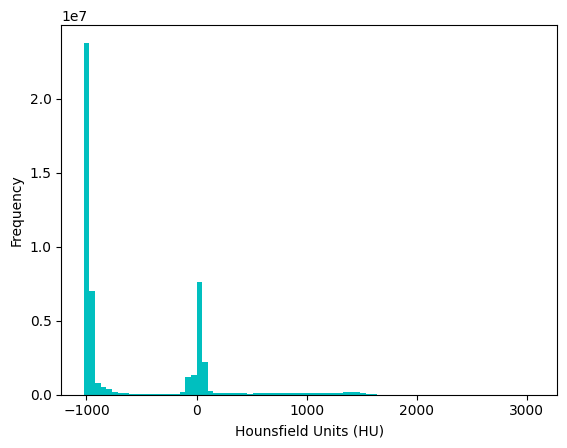

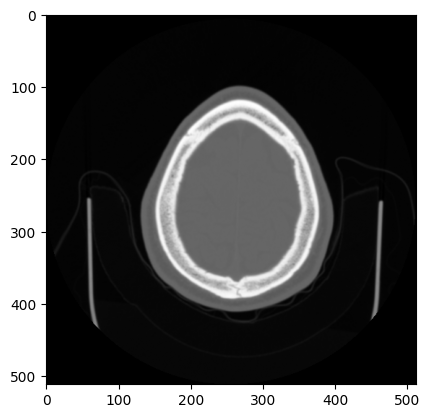

In [12]:
first_patient = load_scan('/content/Facial-Reconstruction-using-Marching-Cubes/Database')
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()


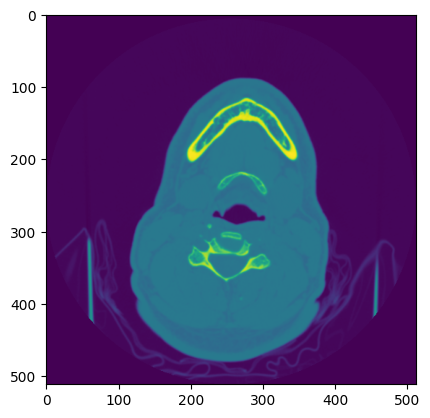

In [13]:
plt.imshow((first_patient_pixels[90]))
plt.show()


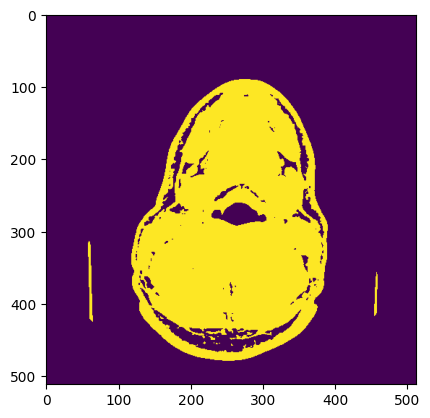

In [14]:
plt.imshow((first_patient_pixels[90]>-50))
plt.show()


In [15]:
pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  At

In [16]:
import os
import pydicom
import numpy as np
from skimage import measure
import open3d as o3d

# Step 1: Load DICOM series
def load_dicom_series(folder_path):
    slices = [pydicom.dcmread(os.path.join(folder_path, f)) for f in os.listdir(folder_path)]
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    volume = np.stack([s.pixel_array for s in slices])
    return volume, slices

# Step 2: Convert to Hounsfield Units if CT
def convert_to_hu(volume, slices):
    intercept = slices[0].RescaleIntercept
    slope = slices[0].RescaleSlope
    hu_volume = volume * slope + intercept
    return hu_volume

# Step 3: Extract surface using marching cubes
def volume_to_mesh(volume, threshold=-300):
    verts, faces, normals, _ = measure.marching_cubes(volume, level=threshold)
    return verts

# Step 4: Convert to Open3D point cloud
def verts_to_point_cloud(verts):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(verts)
    return pcd

# === Main Pipeline ===
folder = "/content/Facial-Reconstruction-using-Marching-Cubes/Database"
volume, slices = load_dicom_series(folder)
volume = convert_to_hu(volume, slices)
verts = volume_to_mesh(volume, threshold=-100)  # Adjust threshold based on anatomy
pcd = verts_to_point_cloud(verts)

# Step 5: Visualize
o3d.io.write_point_cloud("output_100.ply", pcd)


True

In [18]:
# Step 5: Cluster connected components
labels = np.array(pcd.cluster_dbscan(eps=2.0, min_points=10, print_progress=True))

# Step 6: Keep only the largest cluster
largest_cluster_idx = np.bincount(labels[labels >= 0]).argmax()
inlier_mask = labels == largest_cluster_idx
pcd = pcd.select_by_index(np.where(inlier_mask)[0])
o3d.io.write_point_cloud("output_102.ply", pcd)


True